# Figure 4e

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import matplotlib as mpl
from matplotlib import cm

import random
from pathlib import Path
import os
import warnings

import decoupler
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats


from sanbomics.tools import id_map
from sanbomics.plots import volcano
warnings.filterwarnings('ignore')

seed = 777

In [4]:
allen_path = '../public/'
data_path = '../output/'
plot_path = '../plot/'
go_basic_path = '/Users/jiehoonk/DevHub/mnt/annotations/GO/go-basic.obo'
gene2go_path = '/Users/jiehoonk/DevHub/mnt/annotations/GO/gene2go'
m2_path = '/Users/jiehoonk/DevHub/mnt/annotations/GO/m2.all.v2023.2.Mm.symbols.gmt'
mh_path = '/Users/jiehoonk/DevHub/mnt/annotations/GO/mh.all.v2023.2.Mm.symbols.gmt'

#### Define functions

In [5]:
# create pseudobulk & replicates
# condition : columns in adata.obs

def do_pseudobulk(adata, condition, contrast = None, seed = seed):
    print("*** Don't forget to set reference value for each category ***\n")
    
    
    pseudobulk = []
    random.seed(seed)
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) # 2-3 pseudo-replicates per each
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset[idx[i]].X.sum(axis = 0),
                                   var = sample_cell_subset[idx[i]].var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]

            rep_adata.obs['condition'] = sample_cell_subset.obs[condition].iloc[0]
            if contrast:
                if pd.api.types.is_numeric_dtype(sample_cell_subset.obs[contrast]):
                    rep_adata.obs[contrast] = sample_cell_subset.obs[contrast].mean()
                else:
                    rep_adata.obs[contrast] = sample_cell_subset.obs[contrast].iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    design_factors = [x for x in [contrast, 'condition', ] if x is not None]
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = design_factors,
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return pb, dds, de, fig

In [22]:
def gmt_to_decoupler(path):
    from itertools import chain, repeat
    pathways = {}
    
    with Path(path).open('r') as f:
        for line in f:
            name, _, *genes = line.strip().split('\t')
            pathways[name] = genes
    
    return pd.DataFrame.from_records(chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()), columns=['geneset', 'genesymbol'])

In [67]:
adata = sc.read_h5ad(os.path.join(data_path, 'annotated_hvg.h5ad'))
adata = adata.raw.to_adata()
condition = (adata.obs.cell_type == "OPC") & (adata.obs.sample_id != "Control")
adata = adata[condition].copy()

sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))

In [68]:
adata.obs['contrast'] = "TNL"
adata.obs['condition'] = "Tumor"

In [69]:
allen = sc.read_h5ad(os.path.join(allen_path, 'allen_adult.h5ad'))
allen.layers['counts'] = allen.raw.X.copy()
allen.X = allen.layers['counts'].copy()

allen.var['gene_ids'] = allen.var.index
allen.var.index = allen.var['feature_name'].tolist()
allen.raw = allen


np.min(np.sum(allen.X, axis = 1)), np.min(np.sum(allen.X, axis = 0))

(2325.0, 0.0)

In [70]:
allen = allen[allen.obs.cell_type == "oligodendrocyte precursor cell"].copy()
allen = allen[allen.obs.age == "90wk"].copy()
allen.obs.cell_type = "OPC"
allen.obs['condition'] = "Control"
allen.obs['sample_id'] = allen.obs.donor_id.copy()
allen.obs['contrast'] = "Allen"
sc.pp.filter_genes(allen, min_cells = int(allen.shape[0]*0.1))
allen.obs.cell_type.value_counts()

cell_type
OPC    1327
Name: count, dtype: int64

In [71]:
adata.shape, allen.shape

((1835, 9025), (1327, 7739))

In [72]:
bdata = sc.concat([adata, allen])

In [73]:
bdata.obs.condition = bdata.obs.condition.astype('category')
bdata.obs.contrast =bdata.obs.contrast.astype('category')

*** Don't forget to set reference value for each category ***



Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.27 seconds.

Fitting dispersion trend curve...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.31 seconds.

Fitting LFCs...
... done in 0.32 seconds.

Replacing 3 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs Control
            baseMean  log2FoldChange     lfcSE       stat        pvalue  \
Xkr4      806.609099       -1.910022  0.179237 -10.656399  1.627782e-26   
Mrpl15     59.195553        2.038949  0.156821  13.001763  1.195550e-38   
Lypla1     43.963190       -0.513201  0.125374  -4.093351  4.251829e-05   
Tcea1     144.020090        0.663100  0.108973   6.085014  1.164814e-09   
Rgs20     238.444847       -1.104830  0.322605  -3.424714  6.154462e-04   
...              ...             ...       ...        ...           ...   
Rab9       77.400570        2.640790  0.159167  16.591295  8.056390e-62   
Tmsb4x   2294.581908        5.528326  0.267923  20.634033  1.358353e-94   
Frmpd4     98.361545       -2.132546  0.309640  -6.887171  5.691279e-12   
Arhgap6    39.834446       -0.249879  0.152820  -1.635117  1.020245e-01   
Mid1       89.004904       -0.092320  0.148573  -0.621376  5.343525e-01   

                 padj  
Xkr4     1

... done in 0.20 seconds.



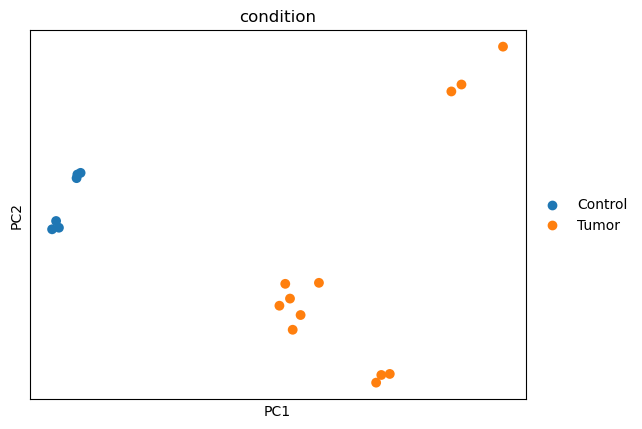

In [74]:
pb, dds, de, fig = do_pseudobulk(bdata, 'condition')

In [75]:
mapper = id_map(species='mouse')
def map_ids(gene):
    if gene in mapper.mapper.keys():
        return mapper.mapper[gene]
    else:
        return gene
de["Symbol"] = de.index.map(map_ids)

de = de[de.baseMean >= 10]
sigs = de[(de.padj < 0.05) & (abs(de.log2FoldChange) > 1)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
Xkr4,806.609099,-1.910022,0.179237,-10.656399,1.627782e-26,1.180986e-25,Xkr4
Mrpl15,59.195553,2.038949,0.156821,13.001763,1.195550e-38,1.520305e-37,Mrpl15
Rgs20,238.444847,-1.104830,0.322605,-3.424714,6.154462e-04,9.653355e-04,Rgs20
Sntg1,1537.498639,-1.743411,0.307330,-5.672759,1.405156e-08,3.191834e-08,Sntg1
Cops5,87.086324,1.635314,0.175693,9.307785,1.305265e-20,6.629645e-20,Cops5
...,...,...,...,...,...,...,...
Rbbp7,77.688539,1.406083,0.132912,10.579046,3.727340e-26,2.651985e-25,Rbbp7
Ctps2,41.530663,-1.039596,0.135681,-7.662049,1.829895e-14,6.255271e-14,Ctps2
Rab9,77.400570,2.640790,0.159167,16.591295,8.056390e-62,3.183412e-60,Rab9
Tmsb4x,2294.581908,5.528326,0.267923,20.634033,1.358353e-94,1.900065e-92,Tmsb4x


#### Volcano plot

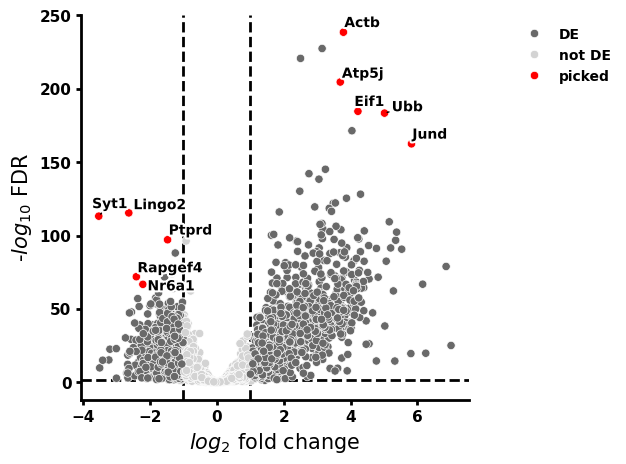

In [109]:
volcano(de, symbol="Symbol", log2fc_thresh = 1, to_label = 5, 
        colors = ["dimgrey", "lightgrey", "red"], save = os.path.join(plot_path, 'Fig4E_OPCwithAllen_volcano'))

In [76]:
reactome = gmt_to_decoupler(mh_path)
reactome

,geneset,genesymbol
0,HALLMARK_ADIPOGENESIS,Abca1
1,HALLMARK_ADIPOGENESIS,Abcb8
2,HALLMARK_ADIPOGENESIS,Acaa2
3,HALLMARK_ADIPOGENESIS,Acadl
4,HALLMARK_ADIPOGENESIS,Acadm
...,...,...
7184,HALLMARK_XENOBIOTIC_METABOLISM,Upb1
7185,HALLMARK_XENOBIOTIC_METABOLISM,Upp1
7186,HALLMARK_XENOBIOTIC_METABOLISM,Vnn1
7187,HALLMARK_XENOBIOTIC_METABOLISM,Vtn


In [77]:
geneset_size = reactome.groupby('geneset').size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

In [78]:
t_stats = sigs[['stat']].copy()
t_stats.rename(columns = {'stat': 'scores'}, inplace = True)
t_stats

,scores
Xkr4,-10.656399
Mrpl15,13.001763
Rgs20,-3.424714
Sntg1,-5.672759
Cops5,9.307785
...,...
Rbbp7,10.579046
Ctps2,-7.662049
Rab9,16.591295
Tmsb4x,20.634033


In [79]:
scores, norm, pvals = decoupler.run_gsea(t_stats.T, reactome[reactome.geneset.isin(gsea_genesets)], source = 'geneset', target='genesymbol')

In [80]:
gsea_results = pd.concat({"score" : scores.T, "norm" : norm.T, "pval" : pvals.T}, axis = 1).droplevel(1, axis = 1).sort_values('pval')
gsea_results

,score,norm,pval
source,,,
HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.601978,6.369176,1.900465e-10
HALLMARK_MYC_TARGETS_V1,0.536025,5.691219,1.261354e-08
HALLMARK_ADIPOGENESIS,0.449952,3.666018,2.463564e-04
HALLMARK_MTORC1_SIGNALING,0.446084,3.586922,3.346041e-04
HALLMARK_UV_RESPONSE_DN,-0.484680,-3.117103,1.826380e-03
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.496687,3.050943,2.281236e-03
HALLMARK_E2F_TARGETS,0.495418,3.015411,2.566311e-03
HALLMARK_KRAS_SIGNALING_DN,-0.636478,-2.884373,3.921940e-03
HALLMARK_FATTY_ACID_METABOLISM,0.422644,2.853938,4.318094e-03


In [81]:
gsea_results['-log10(pval)'] = -np.log10(gsea_results.pval)

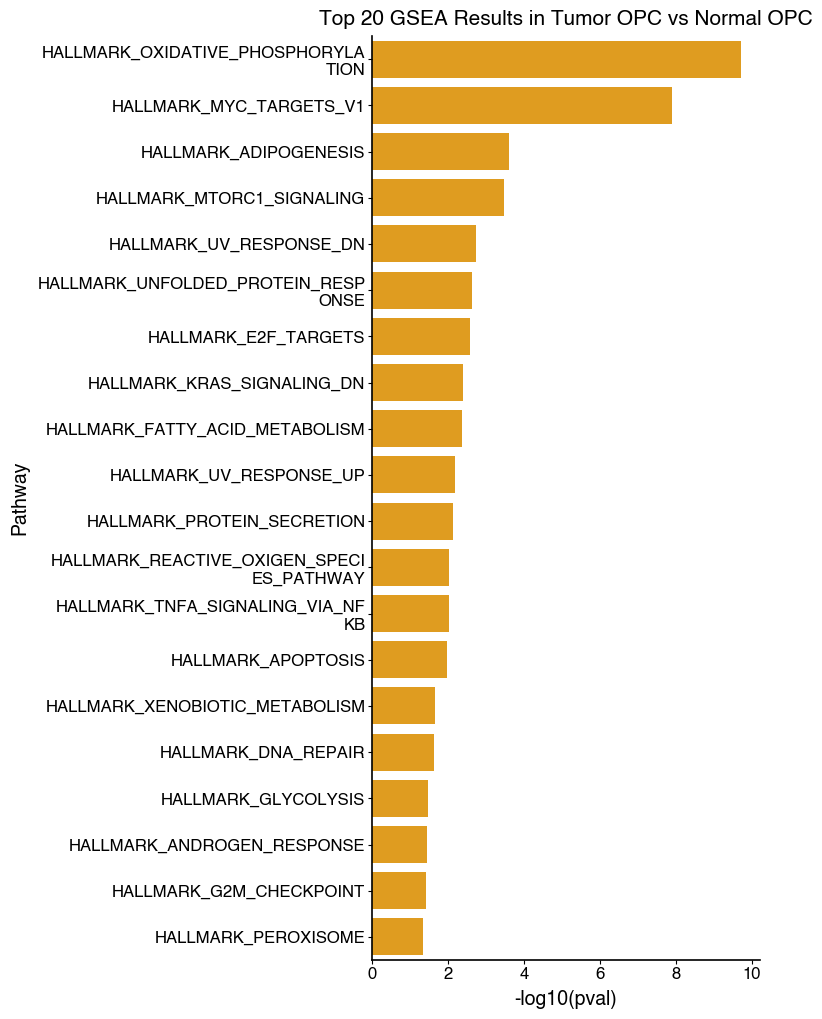

In [83]:
import textwrap

def wrap_labels(ax, width):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_yticklabels()]
    ax.set_yticklabels(labels, rotation=0, ha='right')

with mplscience.style_context():
    plt.figure(figsize = (5, 12))
    ax = sns.barplot(gsea_results.head(20), x = '-log10(pval)', y = gsea_results.head(20).index, color = 'orange')
    wrap_labels(ax, 30)
    plt.xlabel('-log10(pval)')
    plt.ylabel('Pathway')
    plt.title('Top 20 GSEA Results in Tumor OPC vs Normal OPC')
    plt.savefig(os.path.join(plot_path, 'Fig4E_GSEA_OPC(upgraded-MH).pdf'), dpi = 300, format = 'pdf', bbox_inches='tight')
    plt.show()